# The HFM library - A fast marching solver with adaptive stencils

## Part D Applications
## Max-flow / min-cut duality, in a continuous domain.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("../..") # Allow imports from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Tomography_Isotropic','FMM'))

In [50]:
from agd import Eikonal
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd.AutomaticDifferentiation.Optimization import norm_infinity,norm_average,norm
from agd import Domain
from agd import LinearParallel as lp

In [3]:
import numpy as np
import scipy.linalg
from copy import copy
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def reload_packages():
    import importlib
    ad = importlib.reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()
    fd = importlib.reload(sys.modules['agd.FiniteDifferences'])

## 1. The max-flow problem

### 1.1 Problem setting

In [5]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'exportValues':1,
    'exportGeodesicFlow':1,
    'tips':[[np.cos(t),np.sin(t)] for t in np.linspace(0,2.*np.pi)],
    'order':1,
    'stencilGeometry':'Square'
})

# Define the domain
n=101
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=n)

In [7]:
X,Y = hfmIn.Grid()
R=np.sqrt(X**2+Y**2)
capacity = np.abs(R-0.7)+0.1

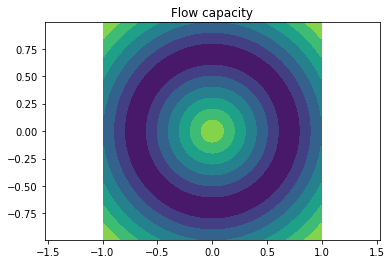

In [8]:
plt.title('Flow capacity'); plt.axis('equal')
plt.contourf(X,Y,capacity);

In [9]:
#seedRegion = (R<0.2)
#hfmIn['seeds'] = np.transpose([X[seedRegion],Y[seedRegion]])
hfmIn.update({
    'seeds':[[0,0]],
    'factoringMethod':'Static',
    'factoringRadius':200,
})

In [10]:
sinkDensity = np.clip(np.minimum(R-0.9,1.-R),a_min=0.,a_max=None)

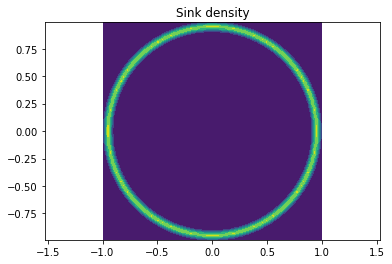

In [11]:
plt.title('Sink density'); plt.axis('equal')
plt.contourf(X,Y,sinkDensity);

In [12]:
hfmIn['metric'] = [1,0,1,0,0]

In [13]:
sinkPos = sinkDensity > 0
hfmIn['inspectSensitivity'] = np.array([X[sinkPos], Y[sinkPos]]).transpose()
hfmIn['inspectSensitivityWeights'] = sinkDensity[sinkPos]
hfmIn['inspectSensitivityLengths'] = [np.sum(sinkPos)]

In [14]:
#hfmIn['model']='Isotropic2'
#hfmIn['cost']=1

In [16]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field seedRadius defaults to 2
***** Warning ! *****
First variation warning : spread seeds are not supported.
********************
Fast marching solver completed in 0.009731 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


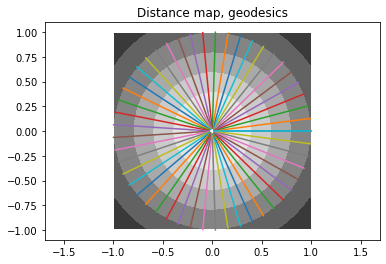

In [18]:
plt.title("Distance map, geodesics"); plt.axis('equal');
plt.contourf(X,Y,hfmOut['values'],cmap='Greys');
for geo in hfmOut['geodesics']: plt.plot(*geo) 

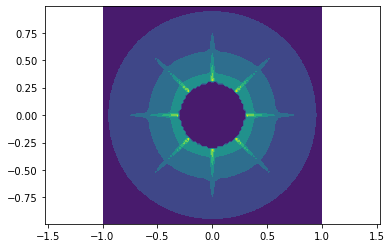

In [19]:
# Clearly, we need to get higher accuracy for the method to be applicable
sens = hfmOut['costSensitivity_0'];
R=np.sqrt(X**2+Y**2)
plt.axis('equal')
plt.contourf(X,Y,sens*(R>0.3));

In [279]:
# Absurd values in Rander case. Very strong axis bias in isotropic case.
#hfmOut['seedSensitivity_0']

In [23]:
X.shape

(101, 101)

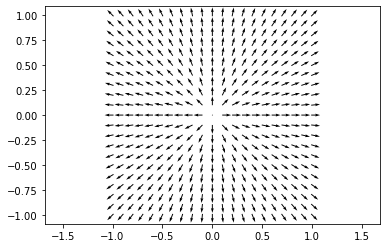

In [24]:
flow = hfmOut['flow']
s=5;
plt.quiver(X[::s,::s],Y[::s,::s],*flow[:,::s,::s]); plt.axis('equal');

In [30]:
def LInfNorm(a): return np.max(np.abs(a))
print("Arrival time error : ", LInfNorm(R-hfmOut['values']))
print("Flow error, X : ", norm_average(flow[0,:,:]*R-X))
print("Flow error, Y : ", norm_average(flow[1,:,:]*R-Y))

Arrival time error :  3.9745984281580604e-14
Flow error, X :  1.164708192375117e-05
Flow error, Y :  1.1647081923603749e-05


### 1.2 Second order advection

We need to solve 
$$
    \mathrm{div} (uV) = 0
$$
with a scheme of order at least two, in order to get usable results. One of the issues is that $u$ is only excpected to converge in the $L^1$ norm.
This PDE is the adjoint of
$$
    \nabla v\cdot V = 0
$$

In [184]:
def V_radial(x): return np.array([1.,0]) #return -x/norm(x,axis=0)

In [201]:
X = hfmIn.Grid()
interior = np.logical_and(norm(X,axis=0)>=0.1,norm(X,axis=0)<0.9)
dom = Domain.MockDirichlet(np.where(interior,np.nan,0.),hfmIn['gridScale'])

In [ ]:
dom.grid_values

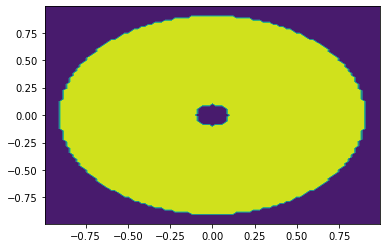

In [207]:
plt.contourf(*X,interior)

In [208]:
def Advection(v,V,dom):
    v,V = (fd.as_field(e,dom.shape) for e in (v,V))
    s0,s1 = np.sign(V).astype(int)
    z = np.zeros_like(s0)
    offsets = np.array([[s0,z],[z,s1]])
    coefs = np.abs(V)
    residue = lp.dot_VV(-coefs*dom.DiffUpwind(v,offsets),V)
    return np.where(dom.interior,residue,v-dom.grid_values)

In [209]:
v = ad.Sparse.identity(shape=dom.shape)
V = V_radial(X)

In [212]:
scheme = Advection(v,V,dom)
op = scheme.tangent_operator()

In [223]:
sinkDensity = np.clip(np.minimum(R-0.6,0.7-R),a_min=0.,a_max=None)

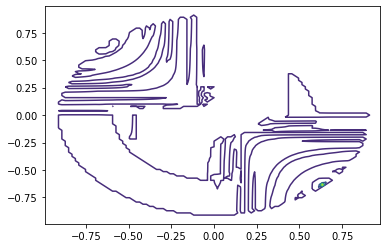

In [224]:
import scipy.sparse.linalg
rhs = sinkDensity
res = scipy.sparse.linalg.spsolve(op,rhs.flatten()).reshape(dom.shape)
plt.contour(*X[:,:-1],res[:-1])

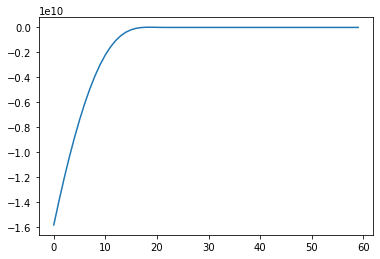

In [225]:
plt.plot(res[60,20:80])

In [180]:
np.max(res)

1.200397988408212